In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터셋 불러오기
PATH = '/content/drive/MyDrive/24-2 가이드프로젝트/'

train_df = pd.read_csv(f'{PATH}train_data_수정.csv')
train_df_replaced = pd.read_csv(f'{PATH}train_data_수정.csv') # 결측치 대체를 위한 변수
test_df = pd.read_csv(f'{PATH}test_data_수정.csv')

### 1. 결측치 처리

In [4]:
# 결측치 제거
train_df.dropna(inplace=True)

# train_df의 복사본을 생성하여 train_df_cleaned로 저장
train_df_cleaned = train_df.copy()
train_df_cleaned.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


In [5]:
# 결측치를 다른 값으로 대체

# workclass의 결측치를 'Never-worked'로 처리
train_df_replaced['workclass'].fillna('Never-worked', inplace=True)

# occupation의 결측치를 'baeksu'로 처리
train_df_replaced['occupation'].fillna('baeksu', inplace=True)

# native.country의 결측치가 있는 행을 제거
train_df_replaced.dropna(subset=['native.country'], inplace=True)

# train_df_replaced의 복사본을 생성하여 train_df_replaced_2로 저장
train_df_replaced_2 = train_df_replaced.copy()
train_df_replaced_2.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


### 2. 범주화

** race의 경우 백인, 아시아계는 수입이 높고, 그 외의 인종은 낮은 수입의 경향성을 보임 따라서 백인, 아시아, 그 외로 범주화

In [6]:
race_mapping = {
    'White': 'rich',
    'Black': 'etc',
    'Amer-Indian-Eskimo': 'etc',
    'Other': 'etc',
    'Asian-Pac-Islander': 'rich'
}

# DataFrame의 'race' 열을 새로운 카테고리로 변환
train_df_cleaned['race'] = train_df_cleaned['race'].replace(race_mapping)
train_df_replaced_2['race'] = train_df_replaced_2['race'].replace(race_mapping)
test_df['race'] = test_df['race'].replace(race_mapping)

** education, education.num
- 고등학교 졸업 이전을 범주화
- education.num만 남기고 education 컬럼은 제거

In [7]:
# Education 카테고리화
education_categorized = {
    'Before High School': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th'],
    'High School Graduate': ['HS-grad'],
    'Some-college' : ['Some-college'],
    'Assocs': ['Assoc-voc', 'Assoc-acdm'],
    'Bachelors': ['Bachelors'],
    'Masters': ['Masters'],
    'Professional School': ['Prof-school'],
    'Doctorate': ['Doctorate']
}

# Education 컬럼 범주화 함수
def categorize_education(education):
    for category, values in education_categorized.items():
        if education in values:
            return category
    return 'Unknown'  # 해당하지 않는 경우

# 범주화 적용하여 기존 education 컬럼에 저장
train_df_cleaned['education'] = train_df_cleaned['education'].apply(categorize_education)
train_df_replaced_2['education'] = train_df_replaced_2['education'].apply(categorize_education)
test_df['education'] = test_df['education'].apply(categorize_education)

# education.num 컬럼 제거
train_df_cleaned.drop(columns=['education.num'], inplace=True)
train_df_replaced_2.drop(columns=['education.num'], inplace=True)
test_df.drop(columns=['education.num'], inplace=True)

** relationship, marital.status 범주화
-  결혼 상태와 가족 관계를 기반으로 새로운 범주 지정
- Husband나 Wife는 'Married'
- Never-married는 'Single'
- Divorced, Separated, Widowed는 'Divorced/Separated/Widowed'로,
- 나머지 경우는 'Other'로 분류

In [8]:
# 범주화 함수 정의
# marital.status 컬럼 범주화
def categorize_marital_status(status):
    if status in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'Married'
    elif status == 'Never-married':
        return 'Single'
    else:
        return 'Others'

# 범주화 적용
train_df_cleaned['marital.status'] = train_df_cleaned['marital.status'].apply(categorize_marital_status)
train_df_replaced_2['marital.status'] = train_df_replaced_2['marital.status'].apply(categorize_marital_status)
test_df['marital.status'] = test_df['marital.status'].apply(categorize_marital_status)


# 원래의 relationship 제거
train_df_cleaned.drop(columns=['relationship'], inplace=True)
train_df_replaced_2.drop(columns=['relationship'], inplace=True)
test_df.drop(columns=['relationship'], inplace=True)

** occupation : 직종별로 범주화
- Management/Professional: 경영진 및 전문직
- Technical/Skilled Labor: 기술직 및 숙련 노동자
- Sales/Service: 판매 및 서비스직
- Administrative/Clerical Support :사무 및 행정직
- Manual Labor: 육체 노동
- Other Occupations: 기타 직업 (예: 가사도우미, 군인 등)

In [9]:
# occupation 범주화 함수
def categorize_occupation(occupation):
    if occupation in ['Exec-managerial', 'Prof-specialty']:
        return 'Management/Professional'
    elif occupation in ['Tech-support', 'Craft-repair', 'Machine-op-inspct']:
        return 'Technical/Skilled Labor'
    elif occupation in ['Sales', 'Other-service', 'Handlers-cleaners']:
        return 'Sales/Service'
    elif occupation in ['Transport-moving', 'Farming-fishing', 'Protective-serv']:
        return 'Manual Labor'
    elif occupation == 'Adm-clerical':
        return 'Administrative/Clerical Support'
    elif occupation in ['Priv-house-serv', 'Armed-Forces']:
        return 'Other Occupations'
    else:
        return 'Unknown'

# 기존 칼럼에 적용
train_df_cleaned['occupation'] = train_df_cleaned['occupation'].apply(categorize_occupation)
train_df_replaced_2['occupation'] = train_df_replaced_2['occupation'].apply(categorize_occupation)
test_df['occupation'] = test_df['occupation'].apply(categorize_occupation)

** workclass : 고용 형태 범주화

- Private Employment: 민간 고용 (사기업, 자영업 등)
- Government Employment: 정부 고용 (주정부, 연방정부 등)
- Not in Labor Force: 노동력에 참여하지 않는 사람들 (무급, 실업자 등)

In [10]:
# 고용 형태 범주화 함수
def categorize_workclass(workclass):
    if workclass in ['Private', 'Self-emp-inc', 'Self-emp-not-inc']:
        return 'Private Employment'
    elif workclass in ['Local-gov', 'State-gov', 'Federal-gov']:
        return 'Government Employment'
    elif workclass in ['Without-pay', 'Never-worked']:
        return 'Not in Labor Force'
    else:
        return 'Unknown'

# 기존 칼럼에 적용
train_df_cleaned['workclass'] = train_df_cleaned['workclass'].apply(categorize_workclass)
train_df_replaced_2['workclass'] = train_df_replaced_2['workclass'].apply(categorize_workclass)
test_df['workclass'] = test_df['workclass'].apply(categorize_workclass)

** native.country 범주화 (미국과 기타 국가로 구분)


In [11]:
# native.country 범주화

train_df_cleaned['native.country'] = train_df_cleaned['native.country'].apply(lambda x: 'US' if x == 'United-States' else 'Others')
train_df_replaced_2['native.country'] = train_df_replaced_2['native.country'].apply(lambda x: 'US' if x == 'United-States' else 'Others')
test_df['native.country'] = test_df['native.country'].apply(lambda x: 'US' if x == 'United-States' else 'Others')

** fnlwgt 컬럼 제거

In [12]:
train_df_cleaned.drop(columns=['fnlwgt'], inplace=True)
train_df_replaced_2.drop(columns=['fnlwgt'], inplace=True)
test_df.drop(columns=['fnlwgt'], inplace=True)

### 3. 이상치 처리

** capital.gain과 capital.loss의 이상치 처리

- 자본 거래나 투자가 없는 사람들은 이 값이 0으로 기록될 수 있음
- 특히 고소득층이나 특정 투자 활동을 하는 사람들이 해당

In [13]:
# 자본 순이익을 나타내는 새로운 컬럼 생성
train_df_cleaned['capital_net'] = train_df_cleaned['capital.gain'] - train_df_cleaned['capital.loss']
train_df_replaced_2['capital_net'] = train_df_replaced_2['capital.gain'] - train_df_replaced_2['capital.loss']
test_df['capital_net'] = test_df['capital.gain'] - test_df['capital.loss']

In [14]:
# 원래 컬럼 제거
train_df_cleaned.drop(columns=['capital.gain', 'capital.loss'], inplace=True)
train_df_replaced_2.drop(columns=['capital.gain', 'capital.loss'], inplace=True)
test_df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

**age 컬럼 : Box-Cox 변환 적용


In [15]:
from scipy import stats

# Box-Cox 변환 적용 : age 컬럼
train_df_cleaned['age'], fitted_lambda = stats.boxcox(train_df_cleaned['age'])
train_df_replaced_2['age'], fitted_lambda = stats.boxcox(train_df_replaced_2['age'])

# test 데이터에도 동일하게 적용
test_df['age'], fitted_lambda = stats.boxcox(test_df['age'])

# Box-Cox 변환 후 fitted lambda 값 출력
print(f"Fitted Lambda: {fitted_lambda}")

Fitted Lambda: 0.20335780896363145


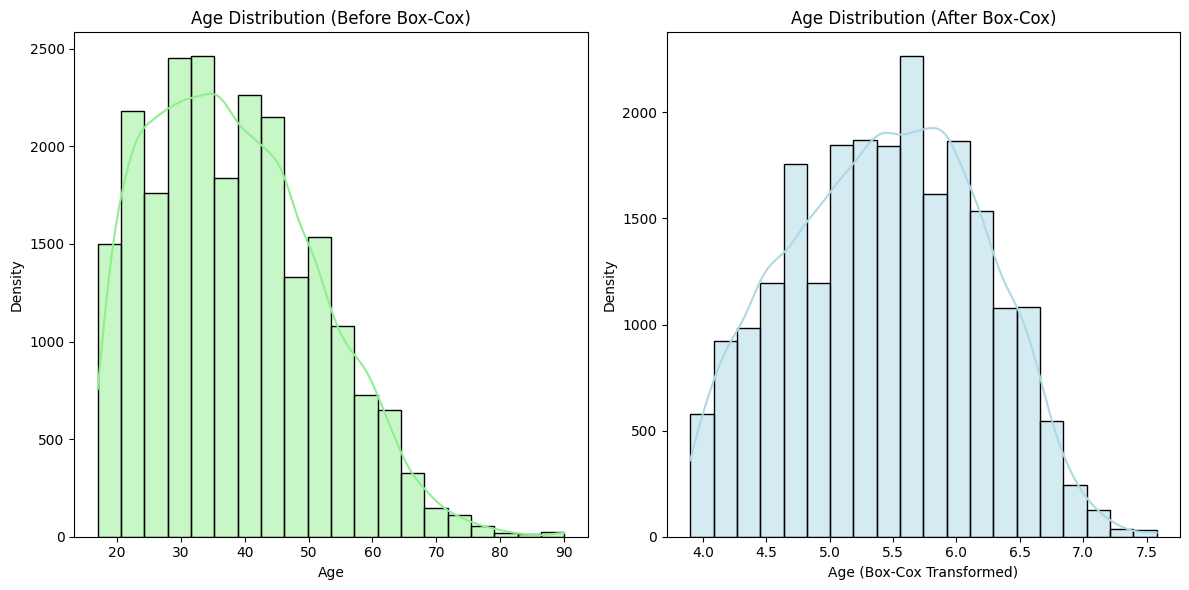

In [16]:
# Box-Cox 변환 전후 차이 시각화 (히스토그램 + KDE)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 변환 전 age 분포
sns.histplot(train_df['age'], bins=20, kde=True, color='lightgreen', ax=axs[0], edgecolor='black')
axs[0].set_title('Age Distribution (Before Box-Cox)')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')

# 변환 후 age_boxcox 분포
sns.histplot(train_df_cleaned['age'], bins=20, kde=True, color='lightblue', ax=axs[1], edgecolor='black')
axs[1].set_title('Age Distribution (After Box-Cox)')
axs[1].set_xlabel('Age (Box-Cox Transformed)')
axs[1].set_ylabel('Density')
plt.tight_layout()
plt.show()

** hours.per.week

In [17]:
# hours.per.week에서 20시간 미만, 65이상의 값 제거

train_df_cleaned = train_df_cleaned[(train_df_cleaned['hours.per.week'] > 20) & (train_df_cleaned['hours.per.week'] < 65)]
train_df_replaced_2 = train_df_replaced_2[(train_df_replaced_2['hours.per.week'] > 20) & (train_df_replaced_2['hours.per.week'] < 65)]
test_df = test_df[(test_df['hours.per.week'] > 20) & (test_df['hours.per.week'] < 65)]

In [18]:
### 전처리 진행 후 train/test dataset
train_cleaned = train_df_cleaned.copy(deep=True)
test_cleaned = test_df.copy(deep=True)

train_replaced_2 = train_df_replaced_2.copy(deep=True)
test_replaced = test_df.copy(deep=True)

범주형 변수 인코딩 : LABEL ENCODING

In [19]:
from sklearn.preprocessing import LabelEncoder
# LabelEncoder 생성 및 적용
label_encoders = {}

for column in train_cleaned.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()

    # Train 데이터를 인코딩
    train_cleaned[column] = label_encoders[column].fit_transform(train_cleaned[column])

    # Test 데이터를 인코딩
    test_cleaned[column] = label_encoders[column].transform(test_cleaned[column])

In [20]:
# 결측치 대체된 데이터에 대해서도 동일하게 적용
from sklearn.preprocessing import LabelEncoder
# LabelEncoder 생성 및 적용
label_encoders = {}

for column in train_replaced_2.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()

    # Train 데이터를 인코딩
    train_replaced_2[column] = label_encoders[column].fit_transform(train_replaced_2[column])

    # Test 데이터를 인코딩
    test_replaced[column] = label_encoders[column].transform(test_replaced[column])

정규화 및 스케일링

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 수치형 변수
numeric_columns = ['age','capital_net','hours.per.week']

# StandardScaler 초기화
scaler = StandardScaler()

# Train 데이터에 대해 StandardScaler 학습
train_cleaned[numeric_columns] = scaler.fit_transform(train_cleaned[numeric_columns])

# Test 데이터에 대해 동일한 스케일러 적용
test_cleaned[numeric_columns] = scaler.transform(test_cleaned[numeric_columns])

In [22]:
# 결측치 대체된 데이터에 대해서도 동일하게 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 수치형 변수
numeric_columns = ['age','capital_net','hours.per.week']

# StandardScaler 초기화
scaler = StandardScaler()

# Train 데이터에 대해 StandardScaler 학습
train_replaced_2[numeric_columns] = scaler.fit_transform(train_replaced_2[numeric_columns])

# Test 데이터에 대해 동일한 스케일러 적용
test_replaced[numeric_columns] = scaler.transform(test_replaced[numeric_columns])

In [23]:
# train 데이터프레임을 CSV 파일로 저장
train_cleaned.to_csv('train_data_cleaned.csv', index=False)

# test 데이터프레임을 CSV 파일로 저장
test_cleaned.to_csv('test_data_cleaned.csv', index=False)

In [24]:
# 결측치 대체된 데이터
# train 데이터프레임을 CSV 파일로 저장
train_replaced_2.to_csv('train_data_replaced.csv', index=False)

# test 데이터프레임을 CSV 파일로 저장
test_replaced.to_csv('test_data_replaced.csv', index=False)

## 모델 학습 : 결측치 모두 제거

In [ ]:
PATH = '/content/drive/MyDrive/24-2 가이드프로젝트/'

# 데이터 셋 불러오기
train = pd.read_csv(f'{PATH}train_data_cleaned.csv')
test = pd.read_csv(f'{PATH}test_data_cleaned.csv')

In [ ]:
X = train.drop(['income'], axis=1)
y = train['income']
print(X.shape, y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

1. 랜덤 포레스트 (그리드 서치)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Random Forest 모델 선언
rf_model = RandomForestClassifier(random_state=42)

from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV로 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# 모델 학습
grid_search.fit(X_train, y_train)

In [ ]:
# 최적의 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

In [ ]:
# 최적의 모델로 예측
best_rf_model = grid_search.best_estimator_
rf_pred = best_rf_model.predict(X_valid)

# 정확도 계산
rf_score = accuracy_score(y_valid, rf_pred)
print(f"Random Forest 모델 정확도: {rf_score * 100:.2f}%")

### 모델의 test set 성능 확인

In [ ]:
#test score 출력을 위한 x,y 데이터 분리
test_x = test.drop('income', axis=1)
test_y = test['income']

In [ ]:
from sklearn.metrics import classification_report

# 테스트 세트 성능 확인
rf_final_prediction = best_rf_model.predict(test_x)
rf_score_test = accuracy_score(test_y, rf_final_prediction)

# 정확도
print(f"Random Forest test set 모델 정확도: {rf_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, rf_final_prediction))

### feature importance (선택)

In [ ]:
# Feature importance 추출
importances = best_rf_model.feature_importances_
feature_names = X_train.columns  # 특성 이름

# Feature importance를 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

2. 랜덤포레스트(랜덤서치)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Random Forest 모델 선언
rf_model = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 랜덤 서치 설정
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV로 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 파라미터와 성능 출력
print("최적의 파라미터:", random_search.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score

# 최적의 모델로 예측
best_rf_model = random_search.best_estimator_
rf_pred = best_rf_model.predict(X_valid)

In [ ]:
# 정확도 계산
rf_score = accuracy_score(y_valid, rf_pred)
print(f"Random Forest train set 모델): {rf_score * 100:.2f}%")

In [ ]:
from sklearn.metrics import classification_report

# 테스트 세트 성능 확인
rf_final_prediction = best_rf_model.predict(test_x)
rf_score_test = accuracy_score(test_y, rf_final_prediction)

# 정확도
print(f"Random Forest test set 모델 정확도: {rf_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, rf_final_prediction))

3. XGBOOST (랜덤서치)

In [ ]:
# 필요한 라이브러리 설치
!pip install xgboost lightgbm

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# XGBoost 모델 선언
xgb_model = xgb.XGBClassifier(random_state=42)

# 하이퍼파라미터 분포 설정
xgb_param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV로 최적의 하이퍼파라미터 탐색
xgb_random_search = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=xgb_param_distributions,
                                       n_iter=50, cv=3, n_jobs=-1,
                                       verbose=2, random_state=42)

# 모델 학습
xgb_random_search.fit(X_train, y_train)

In [ ]:
# 최적의 파라미터와 성능 출력
print("최적의 파라미터 (XGBoost):", xgb_random_search.best_params_)

In [ ]:
# 최적의 모델로 검증 세트에 대한 예측
xgb_best_model = xgb_random_search.best_estimator_
xgb_pred = xgb_best_model.predict(X_valid)

# 정확도 계산
xgb_score = accuracy_score(y_valid, xgb_pred)
print(f"XGBoost 모델 정확도 (검증 세트): {xgb_score * 100:.2f}%")

In [ ]:
# 최종 테스트 세트 성능 확인
xgb_final_pred = xgb_best_model.predict(test_x)
xgb_score_test = accuracy_score(test_y, xgb_final_pred)

# 정확도 출력
print(f"XGBoost test set 모델 정확도 (튜닝 후): {xgb_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, xgb_final_pred))

4.LightGBM

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM 모델 선언
lgbm_model = LGBMClassifier(random_state=42)

# 모델 학습
lgbm_model.fit(X_train, y_train)

In [ ]:
# 예측
lgbm_pred = lgbm_model.predict(X_valid)

# 정확도 계산
lgbm_score = accuracy_score(y_valid, lgbm_pred)
print(f"LightGBM 모델 정확도: {lgbm_score * 100:.2f}%")

In [ ]:
# 최종 테스트 세트 성능 확인
lgbm_final_pred = lgbm_model.predict(test_x)
lgbm_score_test = accuracy_score(test_y, lgbm_final_pred)

# 정확도 출력
print(f"LightGBM test set 모델 정확도: {lgbm_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, lgbm_final_pred))

## 모델 학습 : 결측치 대체

In [ ]:
PATH = '/content/drive/MyDrive/24-2 가이드프로젝트/'

# 데이터 셋 불러오기
train = pd.read_csv(f'{PATH}train_data_replaced.csv')
test = pd.read_csv(f'{PATH}test_data_replaced.csv')

In [ ]:
X = train.drop(['income'], axis=1)
y = train['income']
print(X.shape, y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

1. 랜덤포레스트(그리드서치)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Random Forest 모델 선언
rf_model = RandomForestClassifier(random_state=42)

from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV로 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# 모델 학습
grid_search.fit(X_train, y_train)

In [ ]:
# 최적의 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

In [ ]:
# 최적의 모델로 예측
best_rf_model = grid_search.best_estimator_
rf_pred = best_rf_model.predict(X_valid)

# 정확도 계산
rf_score = accuracy_score(y_valid, rf_pred)
print(f"Random Forest 모델 정확도: {rf_score * 100:.2f}%")

### 모델의 test set 성능 확인

In [ ]:
#test score 출력을 위한 x,y 데이터 분리
test_x = test.drop('income', axis=1)
test_y = test['income']

In [ ]:
from sklearn.metrics import classification_report

# 테스트 세트 성능 확인
rf_final_prediction = best_rf_model.predict(test_x)
rf_score_test = accuracy_score(test_y, rf_final_prediction)

# 정확도
print(f"Random Forest test set 모델 정확도: {rf_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, rf_final_prediction))

In [ ]:
# Feature importance 추출
importances = best_rf_model.feature_importances_
feature_names = X_train.columns  # 특성 이름

# Feature importance를 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

2. 랜덤포레스트(랜덤서치)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Random Forest 모델 선언
rf_model = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 랜덤 서치 설정
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV로 최적의 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 파라미터와 성능 출력
print("최적의 파라미터:", random_search.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score

# 최적의 모델로 예측
best_rf_model = random_search.best_estimator_
rf_pred = best_rf_model.predict(X_valid)

In [ ]:
# 정확도 계산
rf_score = accuracy_score(y_valid, rf_pred)
print(f"Random Forest train set 모델): {rf_score * 100:.2f}%")

In [ ]:
from sklearn.metrics import classification_report

# 테스트 세트 성능 확인
rf_final_prediction = best_rf_model.predict(test_x)
rf_score_test = accuracy_score(test_y, rf_final_prediction)

# 정확도
print(f"Random Forest test set 모델 정확도: {rf_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, rf_final_prediction))

3. XGBOOST(랜덤서치)

In [ ]:
# 필요한 라이브러리 설치
!pip install xgboost lightgbm

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# XGBoost 모델 선언
xgb_model = xgb.XGBClassifier(random_state=42)

# 하이퍼파라미터 분포 설정
xgb_param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV로 최적의 하이퍼파라미터 탐색
xgb_random_search = RandomizedSearchCV(estimator=xgb_model,
                                       param_distributions=xgb_param_distributions,
                                       n_iter=50, cv=3, n_jobs=-1,
                                       verbose=2, random_state=42)

# 모델 학습
xgb_random_search.fit(X_train, y_train)

In [ ]:
# 최적의 파라미터와 성능 출력
print("최적의 파라미터 (XGBoost):", xgb_random_search.best_params_)

In [ ]:
# 최적의 모델로 검증 세트에 대한 예측
xgb_best_model = xgb_random_search.best_estimator_
xgb_pred = xgb_best_model.predict(X_valid)

# 정확도 계산
xgb_score = accuracy_score(y_valid, xgb_pred)
print(f"XGBoost 모델 정확도 (검증 세트): {xgb_score * 100:.2f}%")

In [ ]:
# 최종 테스트 세트 성능 확인
xgb_final_pred = xgb_best_model.predict(test_x)
xgb_score_test = accuracy_score(test_y, xgb_final_pred)

# 정확도 출력
print(f"XGBoost test set 모델 정확도 (튜닝 후): {xgb_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, xgb_final_pred))

4.LIGHT GBM

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM 모델 선언
lgbm_model = LGBMClassifier(random_state=42)

# 모델 학습
lgbm_model.fit(X_train, y_train)

In [ ]:
# 예측
lgbm_pred = lgbm_model.predict(X_valid)

# 정확도 계산
lgbm_score = accuracy_score(y_valid, lgbm_pred)
print(f"LightGBM 모델 정확도: {lgbm_score * 100:.2f}%")

In [ ]:
# 최종 테스트 세트 성능 확인
lgbm_final_pred = lgbm_model.predict(test_x)
lgbm_score_test = accuracy_score(test_y, lgbm_final_pred)

# 정확도 출력
print(f"LightGBM test set 모델 정확도: {lgbm_score_test:.5f}")

# 추가적인 성능 평가 지표 출력
print("Classification Report:")
print(classification_report(test_y, lgbm_final_pred))